In [1]:
#!mamba install -c conda-forge autogluon "pytorch=*=cuda*" torchaudio -y #Only run if doing section 2
#from autogluon.tabular import TabularPredictor
#from autogluon.multimodal import MultiModalPredictor
import numpy as np
import pickle
import utils
import matplotlib.pyplot as plt
import math
from torch import nn
from huggingface_hub import snapshot_download

#repo_dir = snapshot_download("ahn1376/bikefusion",local_dir="./bikefusion")

import bikefusion
import textwrap

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### The Problem:

You've been hired by an eccentric bike company as an AI engineer to help with their prototyping software. For your probationary assignment, the company has asked for a tool to help their designers visualize design concepts. They want to provide a partial image, some design parameters that they have selected for the design, and a marketing prompt. Your job is to use your AI magic to create an image of the completed design concept. 

Your manager has "thrown you off the deep end," and isn't the best at answering your questions. For example, since you have no idea how to interpret the designers' jargon, you have no idea what each parameter is referring to on the bike! A lot of the bikes also look very strange or even physically infeasible and nobody seems to be able to explain why. Seems like they *really* want to explore the design space...

Fortunately the company has provided a set of 10,000 previous design concepts (these designers stay busy!). These previous design concepts include the complete image, partial image, design parameters and marketing pitches. This gives you some hope to train a generative model! 

For your probationary assessment, the company has also provided 1,000 test designs to evaluate (partial image, parameters, and marketing pitch), but has not provided the completed images. They want you to use your "AI magic" to predict the complete designs and they will evaluate how accurately you were able to do so. Your job is on the line! How accurately can you predict these design concepts?

### Exploring The Data

We have prepared a helper function to load up the data. Let's call that function and take a look at the different components of our data

In [2]:
partial_images, masks, parametric, description, targets = utils.load_data()
#Targets: final image we're trying to predict
#Partial_images: masked images
#Masks: masks
#Parametric: list of values
#Description: string

In [4]:
print(f"Masked images: array with shape: {partial_images.shape}") # rgb, height 80, width 128
print(f"Masks: array with shape: {masks.shape}") #coordinates of boundaries of mask (singular values, not tuples)
print(f"Parametric: array with shape: {parametric.shape}") #96 parameters
print(f"Description: list with length: {len(description)}") #list of strings
print(f"Images: array with shape: {targets.shape}") #target images

Masked images: array with shape: (10000, 3, 80, 128)
Masks: array with shape: (10000, 4)
Parametric: array with shape: (10000, 96)
Description: list with length: 10000
Images: array with shape: (10000, 3, 80, 128)


Let's have a look at the first entry of the parametric data. We can see that we have a few specified parametric values that aren't labeled in any way. The rest of the values are nans.  

In [3]:
parametric[0] #nans are by design, company has only decided on around half, have to infer what the datapoints mean

array([           nan,            nan,            nan, 6.20937007e+01,
       1.31141113e+02,            nan,            nan,            nan,
       7.63218804e+02, 5.96530067e+01,            nan, 3.11535683e+01,
                  nan,            nan, 1.10350907e+01, 1.04152904e+01,
                  nan,            nan, 5.12534557e+01,            nan,
                  nan,            nan, 1.35300393e+01, 1.44887388e-01,
       3.44191730e-01, 1.36933498e+02, 2.00000000e+00,            nan,
                  nan, 9.00000000e-01,            nan, 1.00000000e+00,
                  nan, 4.96935219e+02, 6.12624222e+01, 4.83649049e+02,
                  nan,            nan, 5.63796245e+02,            nan,
       7.45982037e+01, 5.25287944e+01,            nan, 3.46312256e+01,
       6.44946992e-01, 6.67663753e-01,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan, 6.76637626e+01,            nan,
      

Ok, now let's take a look at the complete images, masked images and the marketing descriptions:

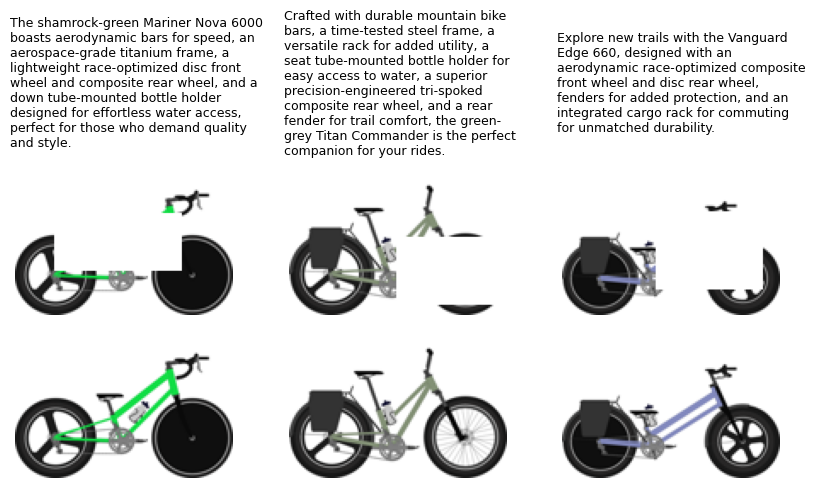

In [5]:
# Visualize 3 masked and complete images side by side
fig, ax = plt.subplots(3, 3, figsize=(10, 6))
random_3 = np.random.choice(range(len(description)), 3, replace=False)

for i in range(3):
    idx = random_3[i]
    wrapped_text = "\n".join(textwrap.wrap(description[idx], width=37))  
    ax[0, i].text(0, 0.5, wrapped_text, fontsize=9, va='center')  # Use va='center' and adjust y position
    partial_im = np.moveaxis(partial_images[idx], 0, -1)
    im = np.moveaxis(targets[idx], 0, -1)
    ax[1, i].imshow(partial_im)
    ax[2, i].imshow(im)
    
    # Turn off axes
    ax[0, i].axis("off")
    ax[1, i].axis("off")
    ax[2, i].axis("off")

plt.show()


In case there is any ambiguity about the mask locations, these are provided too. Let's take a look at the mask information for these three bikes. The mask information contains the indices of the edges of the mask (order: left, bottom, right, top). Remember that we count pixels from top to bottom when dealing with numpy arrays.

In [6]:
masks[random_3]

array([[ 23,  54,  98,  20],
       [ 63,  74, 128,  34],
       [ 55,  65, 118,  19]])

### Starter Code

**How do we fill in the mask of a partial image??**

One strategy is to create a VAE that is trained to reconstruct a full image even if we have a partial encoding. To help the VAE identify masked portions of images during training, we can give it an extra feature that segments where an image is masked.

In the function *add_mask_channel()*, a fourth channel is created that passes the value 1 where the *NaN* mask is present in the image. This way, each image has 4 channels: Red, Green, Blue, and Mask.  For our full images, this fourth channel is all zeros. 

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn
from torch.nn import functional as F
from torch.optim import AdamW

from torchsummary import summary

from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def get_mask_channel(images, masks):
    # Create an empty mask channel with the same spatial dimensions
    mask_channel = np.zeros((images.shape[0], images.shape[2], images.shape[3]))
    
    # Populate the mask channel based on the coordinates in masks
    for i in trange(masks.shape[0]):
        mask_channel[i, masks[i][3]:masks[i][1], masks[i][0]:masks[i][2]] = 1.0

    return mask_channel

# Scale the images for machine learning
def scale_images(images):
    images = images / 255.0 
    return images

#return the image to RGB format
def to_rgb(images):
    img = images * 255
    return img.astype(np.uint8)

        

In [5]:
processed_partial_images = scale_images(partial_images)
processed_targets = scale_images(targets)

mask_channel = get_mask_channel(processed_partial_images, masks)[:, None, :, :]
processed_partial_images = np.concatenate([processed_partial_images, mask_channel], axis=1)

print(processed_partial_images.shape)
print(processed_targets.shape)


100%|██████████| 10000/10000 [00:00<00:00, 74698.73it/s]


(10000, 4, 80, 128)
(10000, 3, 80, 128)


In [6]:
# Convert the numpy arrays to PyTorch tensors
processed_partial_images = torch.tensor(processed_partial_images, dtype=torch.float32)
processed_targets = torch.tensor(processed_targets, dtype=torch.float32)

# Test-Train split
train_masked, val_masked, train_targets, val_targets = train_test_split(processed_partial_images, processed_targets, test_size=0.1, random_state=42)

# Create a DataLoader
train_masked = train_masked.to(device)
train_targets = train_targets.to(device)

train_data = TensorDataset(train_masked, train_targets)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)



In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional layers
        self.conv1 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Flatten and fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 8, 128)  # Output for both mean and variance layers

        # Separate layers for mean and variance
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_var = nn.Linear(128, latent_dim)

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = self.flatten(x)
        x = F.relu(self.fc1(x))

        # Compute mean and variance
        mu = self.fc_mean(x)
        logvar = self.fc_var(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        # Fully connected layers to expand the latent space
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 64 * 5 * 8)

        # Upsampling and transpose convolution layers
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv3 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.upconv4 = nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 64, 5, 8)

        x = F.relu(self.upconv1(x))
        x = F.relu(self.upconv2(x))
        x = F.relu(self.upconv3(x))
        x = self.upconv4(x)  # Sigmoid for output in range [0, 1]
        return x
    
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder_net = Encoder(latent_dim)
        self.decoder_net = Decoder(latent_dim)
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        mu, logvar = self.encoder_net(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, x):
        return torch.sigmoid(self.decoder_net(x))

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        output = self.decode(z)
        return output, mu, logvar

    def show_summaries(self, input_size, batch_size=1):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.encoder_net.to(device)
        self.decoder_net.to(device)
        
        print("Encoder Summary:")
        summary(self.encoder_net, input_size=input_size, batch_size=batch_size, device=str(device))

        print("\nDecoder Summary:")
        summary(self.decoder_net, input_size=(self.latent_dim,), batch_size=batch_size, device=str(device))


def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KLD * 0.005


In [12]:
def train_vae_model(train_loader, model, optimizer,num_epochs, device):
  model = model.to(device)
  model.train()

  for epoch in range(num_epochs):
    logs = {}
    running_loss = 0.0
    prog = tqdm(enumerate(train_loader), total=len(train_loader))
    n = 0
    for batch_idx, (data, target) in prog:
      data = data.to(device)
      target = target.to(device)

      optimizer.zero_grad()
      output, mu, logvar = model(data)
      loss = vae_loss(output, target, mu, logvar)
      loss.backward()
      optimizer.step()
      running_loss += loss.detach() * data.size(0)
      n += data.size(0)

      prog.set_description(f"Epoch {epoch+1}/{num_epochs}")
      prog.set_postfix_str(f"Loss: {loss.item():.7f} | Running Loss: {running_loss/n:.7f}")

    epoch_loss = running_loss / len(train_loader)
    logs['loss'] = epoch_loss.item()

In [13]:
model = VAE(latent_dim=128).to(device)
model.show_summaries(input_size=(4, 80, 128))

Encoder Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 8, 80, 128]             296
         MaxPool2d-2             [1, 8, 40, 64]               0
            Conv2d-3            [1, 16, 40, 64]           1,168
         MaxPool2d-4            [1, 16, 20, 32]               0
            Conv2d-5            [1, 32, 20, 32]           4,640
         MaxPool2d-6            [1, 32, 10, 16]               0
            Conv2d-7            [1, 64, 10, 16]          18,496
         MaxPool2d-8              [1, 64, 5, 8]               0
           Flatten-9                  [1, 2560]               0
           Linear-10                   [1, 128]         327,808
           Linear-11                   [1, 128]          16,512
           Linear-12                   [1, 128]          16,512
Total params: 385,432
Trainable params: 385,432
Non-trainable params: 0
--------------

In [16]:
optimizer = AdamW(model.parameters(), lr=1e-3) #AdamW is the name of the optimizer

num_epochs = 200
train_vae_model(train_loader, model, optimizer, num_epochs, device)

Epoch 200/200: 100%|██████████| 141/141 [00:36<00:00,  3.82it/s, Loss: 0.0201767 | Running Loss: 0.0196249]


In [8]:
def combine_orig_and_pred(masked_images, predicted_images, masks):
    combination = predicted_images*masks + masked_images*(1-masks)
    return combination

In [16]:
val_masked_im = val_masked.detach().cpu().numpy()[:,:3,:,:]
val_mask_channel = val_masked.detach().cpu().numpy()[:,3:4,:,:]

# Get the reconstructed images
model.eval()
with torch.no_grad():
    recon_masked_images, _, _ = model(val_masked.clone().to(device))

recon_masked_images = recon_masked_images.detach().cpu().numpy()

combined_reconstructed_images = combine_orig_and_pred(val_masked_im, recon_masked_images, val_mask_channel)

final_reconstructions = to_rgb(combined_reconstructed_images)

img_ground_truth = to_rgb(val_targets.detach().cpu().numpy())

Now we display 3 random images to visualize our reconstruction results?

Masked images Reconstruction


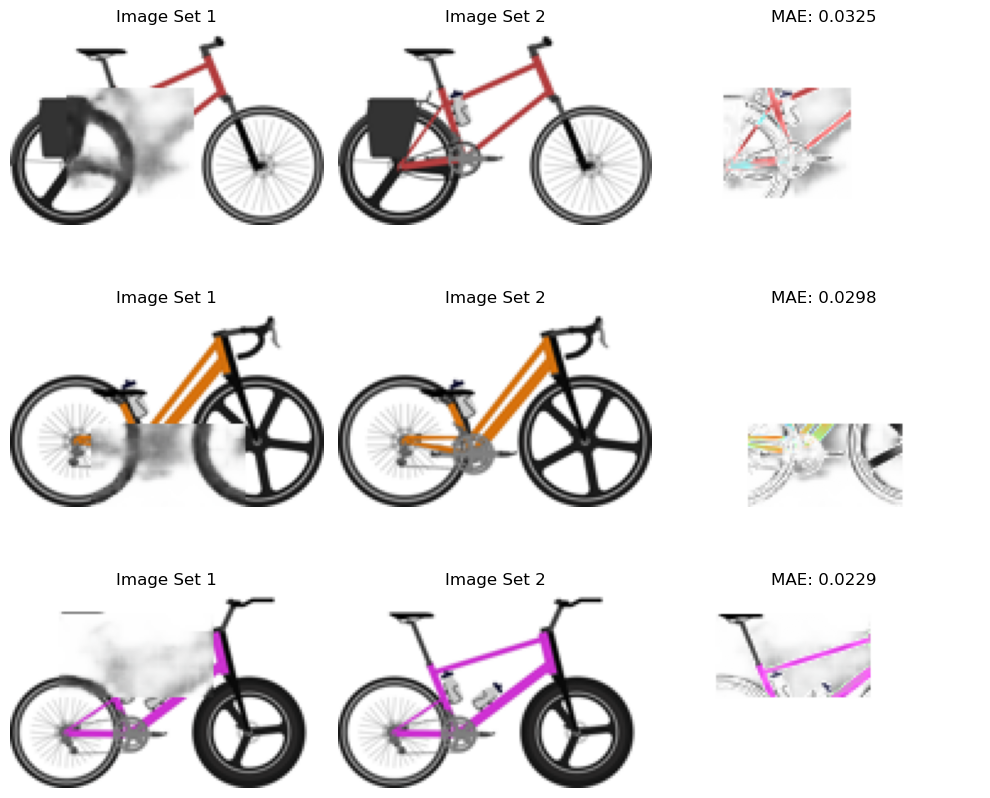

In [17]:
# Display random 3 images
random_3 = np.random.choice(range(len(final_reconstructions)), 3, replace=False)
print("Masked images Reconstruction")
utils.display_images_residual(final_reconstructions[random_3], img_ground_truth[random_3])

We can see that our VAE is very good at learning predictable features like the bike wheels when part of the wheel is unmasked. However, for some of the features that are difficult to deduce based on the rest of the bike, such as the frame, the VAE doesn't do a great job. This is also the case when an entire features (wheel, handles, cargo rack) are hidden. But can we expect it to correctly guess? Often times there isn't enough context to deduce the frame shape or the component types without the parametric or text information. This is where you can gain an advantage from the parametric or text data. But even without the additional information, there is clearly room for improvement. For example, even though the model can sometimes see the frame's color, it tensds to just guess on the color with a fuzzy gray. 

Let's calculate our composite score. This is the metric we will use to evaluate your submission. So if the validation set were the test set, this would be your submission score. Our composite score is a weighted combination of Mean Absolute Error and Structural Similarity Index Metric (SSIM). Exact reconstructions will earn a score of 1, while random noise will earn somewhere around a 0.5. The theoretical mimimum score is 0. 

In [18]:
mean_score, scores = utils.calculate_composite_score(final_reconstructions, img_ground_truth)
print(f"Mean Composite Score: {mean_score}")

Mean Composite Score: 0.9506307244300842


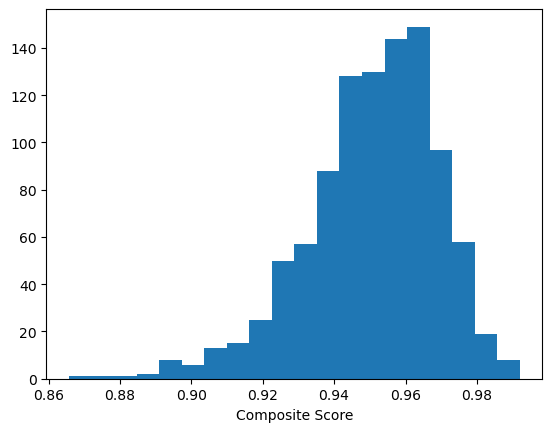

In [19]:
plt.hist(scores, bins=20)
plt.xlabel("Composite Score")
plt.show()

If we hadn't merged predictions with the non-masked regions:

In [20]:
print(f"Mean Composite Score: {utils.calculate_composite_score(to_rgb(recon_masked_images), img_ground_truth)[0]}")

Mean Composite Score: 0.9102590084075928


If we just use the incomplete picture directly as our prediction for the complete picture:

In [21]:
print(f"Mean Composite Score: {utils.calculate_composite_score(to_rgb(val_masked_im), img_ground_truth)[0]}")

Mean Composite Score: 0.9007602334022522


### How can I improve this model??

Your job is is create better sample images given the masked data. Some strategies that the TA's recommend trying are: 

1) Try another type of deep generative model, such as a Diffusion Model or a non-generative forward model, such as a U-net. Please ask the TA's for sample code or use the code from the demo! Diffusion models are the state of the art DGM for image synthesis and they will provide high quality images for this challenge problem. U-Nets are very strong models for image-image translation and editing. We highly recommend trying these approaches!

2) Create more masked images (you can create as many masked samples for each image in the training data as you want). The mask function is in the utils file. 

3) Utilize the masked parametric information or the text data to improve predictions. The are usually many possibilities for what may lie inside the masked areas. For a model to nail this prediction without more information is not only difficult but *impossible*. It is guessing! Take away some of the uncertainty using the parametric or text information. 

    a) To utilize the parametric data, you will have to deal with the nan values. For a basic strategy, you can perform imputation. For a more advanced strategy you can mask losses to only factor i the available data. 

    b) To utilize the text data, you need to find a text representation. A simple approach can use a word-frequency based "bag of words" approach to quantify the counts of certain key words. For a more advanced approach, we recommend using a pre-trained text embedding model to map each text string into a parametric vector. 

    c) Next, you need to add your parametric data or text representation to the model. Consult Demo 6 on multimodal learning to see how to implement hybrid neural networks. You will have to synthesize this knowledge with Demo 8 to implement a mixed-modality generative model.





### Diffusion Model Testing (FAILED Solution Testing) ###

When first running this file, I found that one way we can improve on the model's performance is to use a diffusion model (like the one we used in demo 9) instead of the VAE. Here are some tests:

This test ultimately failed as I realized that I could achieve much faster solutions through Colab.

In [9]:
Diffuser = bikefusion.load_bikefusion()

#Util Functions
def combine_orig_and_pred(masked_images, predicted_images, masks):
    combination = predicted_images*masks + masked_images*(1-masks)
    return combination

def get_mask_channel(images, masks):
    # Create an empty mask channel with the same spatial dimensions
    mask_channel = np.zeros((images.shape[0], images.shape[2], images.shape[3]))

    # Populate the mask channel based on the coordinates in masks
    for i in trange(masks.shape[0]):
        mask_channel[i, masks[i][3]:masks[i][1], masks[i][0]:masks[i][2]] = 1.0

    return mask_channel

partial_images, masks, parametric, description, targets  = utils.load_data(split="test")
test_partials = bikefusion.preprocess(partial_images)

mask_maps = get_mask_channel(partial_images, masks)[:, None, :, :]

mask_maps_test = (1-bikefusion.preprocess(255*(1-mask_maps)))/2

batch_size = 32
n_batches = (len(test_partials) + batch_size - 1) // batch_size

inpaintings = []

for i in trange(n_batches):
    # First get the current batch of partial images from the test set
    masked_samples_tens = torch.tensor(test_partials[i*batch_size:(i+1)*batch_size]).to(Diffuser.device)
    sample_masks_tens = torch.tensor(mask_maps_test[i*batch_size:(i+1)*batch_size]).to(Diffuser.device)

    # define The guidance objective for this bactch
    def sample_guidance(denoised_images, timestep): #Calculates said error
        un_masked_portion = denoised_images*((1-sample_masks_tens)==1) + sample_masks_tens
        error = torch.square(masked_samples_tens - un_masked_portion).sum() * (1000-timestep)/1000

        return error

    infilled = Diffuser.generate(masked_samples_tens, num_inference_steps=10, guidance_function=sample_guidance, guidance_scale=0.1)

    inpaintings.append(infilled)

inpaintings = np.concatenate(inpaintings, axis=0)

n = 8
idx = np.random.choice(len(inpaintings), n, replace=False)

# plot the images
bikefusion.visualize_imagesets((test_partials[idx]+1)/2,
                    mask_maps_test[idx],
                    (inpaintings[idx]+1)/2,
                    titles=["Masked Image", "Mask Map", "In-Painted Image"])

final_images = (mask_maps_test) * inpaintings + test_partials * (1-mask_maps_test) # keep original masked images exactly

final_images = bikefusion.postprocess(final_images) # Now this is ready for submission

np.save("submission.npy",final_images) # Note this will be saved in 2155-Challenge-Problem-3/ directory


#Post Process (Final Generations)
n = 8
idx = np.random.choice(len(final_images), n, replace=False)

# plot the images
bikefusion.visualize_imagesets(partial_images[idx], final_images[idx], titles=["Masked Images", "In-Painted Image"])

/Users/albarh22/Desktop/Coding Projects/2.155/2155-Challenge-Problem-3/bikefusion/bikefusion/diffusion.py:110: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = tor

Epoch information not found in checkpoint setting epoch to 0


  0%|          | 0/32 [00:00<?, ?it/s]/var/folders/zd/cww5hp2j0cj1n_8kn3hnh9c00000gn/T/ipykernel_1030/2980588710.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masked_samples_tens = torch.tensor(test_partials[i*batch_size:(i+1)*batch_size]).to(Diffuser.device)
/var/folders/zd/cww5hp2j0cj1n_8kn3hnh9c00000gn/T/ipykernel_1030/2980588710.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_masks_tens = torch.tensor(mask_maps_test[i*batch_size:(i+1)*batch_size]).to(Diffuser.device)
 12%|█▎        | 4/32 [2:12:02<15:24:16, 1980.60s/it]


KeyboardInterrupt: 

### Imputation (Solution Testing) ###
The main difficulty of the parametric data is the number of NAN values that are contained within it. In order to fix this, we can use imputation methods from scikit learn. After fixing this problem, we can try and piece together what these parameters mean such that we can apply it to our model.

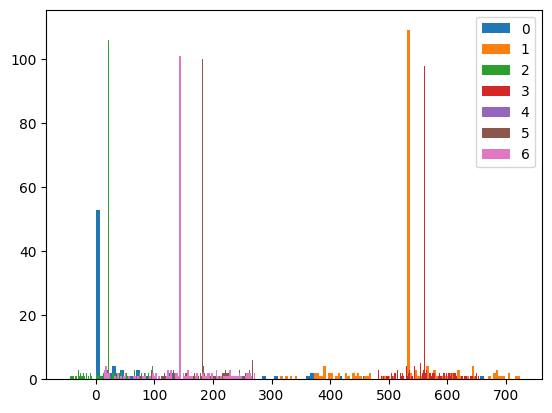

In [16]:
#Imputation: SimpleImputer and IterativeImputer
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
param_imp = imp.fit_transform(parametric)

plt.hist(param_imp[0].flatten(), bins=100) #Data Visualization to better understand each of the paramters


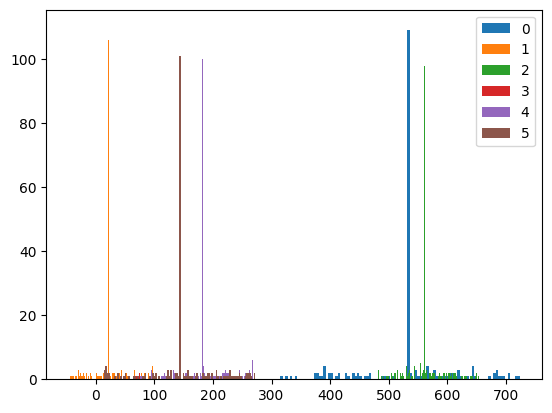

In [17]:
plt.hist(param_imp[:200,0].flatten(), bins=100) #Plot all values of first feature
plt.hist(param_imp[:200,1].flatten(), bins=100) 
plt.hist(param_imp[:200,2].flatten(), bins=100)
plt.hist(param_imp[:200,3].flatten(), bins=100)
plt.hist(param_imp[:200,4].flatten(), bins=100) 
plt.hist(param_imp[:200,5].flatten(), bins=100) 
plt.legend([0,1,2,3,4,5]) #First 5 features and their data distributions

### Diffusion & NN Hybrid (FALIED Solution Testing)###
We can combine the diffusion model with a neural network in order to combine both the image and parametric information in order to produce a more accurate output. Although promising, I got quite stuck on how exactly to implement the 

In [12]:
"""
U-Net: In order to use "off the shelf" U-Nets as described in demo 9, I will use the same pre-processing method to modify the images
to be transformed into 128x128 images with scaled values of [-1,1].
"""

import torch.nn.functional as F
#U-net from Demo 8

# The Unet architecture is borrowed from this code:
# https://colab.research.google.com/drive/1sjy9odlSSy0RBVgMTgP7s99NXsqglsUL?usp=sharing#scrollTo=qWw50ui9IZ5q

class DownBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
        self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], kernel_size=3, padding=2)

        # Downsample
        self.downs = nn.ModuleList([DownBlock(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([UpBlock(up_channels[i], up_channels[i+1], \
                                        time_emb_dim) \
                    for i in range(len(up_channels)-1)])

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, (3, 1), padding=(0, 1))

    def forward(self, x, timestep):

        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        x = x[:, :, :, :64]

        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)

        for up in self.ups:
            residual_x = residual_inputs.pop()

            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        out = self.output(x)
        return out[:, :, :, :65]
    

#DNN
class DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DNN, self).__init__()

        # Define fully connected layers
        self.fc1 = nn.Linear(input_size, 128)  # Input size is the number of features in the parametric data
        self.fc2 = nn.Linear(128, 128)         # 128 inputs, 128 outputs
        self.fc3 = nn.Linear(128, 128)         # 128 inputs, 128 outputs
        self.fc4 = nn.Linear(128, num_classes) # Output size matches the number of classes

    def forward(self, x):
        # Pass through fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        # Output layer with no activation (logits)
        x = self.fc4(x)  # Output size is [batch x num_classes]
        return x


#Hybrid NN Definition
class HybridDNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.unet = SimpleUnet()
        self.dnn = DNN(input_size, num_classes=512)
        self.combine_fc = nn.Sequential(
            nn.Linear(1024 + 1024, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 128 * 128),  
        )

    def forward(self, images, param, desc):
        unet_features = self.unet(images).flatten(start_dim=1)
        dnn_features = self.dnn(param, desc)
        combined = torch.cat([unet_features, dnn_features], dim=1)
        output = self.combine_fc(combined)
        return output.view(-1, 3, 128, 128)
    

input_size = 96

# Initialize the hybrid model
model_hybrid = HybridDNN(input_size = input_size)
model_hybrid.to(device)

# Print the model architecture for reference
combined_input_size = param_size + (1 * image_height * image_width)  # Size after concatenating flattened image and parametric data
summary(model_hybrid, (combined_input_size,))  # Single input after concatenation

TypeError: HybridDNN.forward() missing 2 required positional arguments: 'param' and 'desc'

In [3]:
#Model Testing
from torch.optim import Adam

def closed_form_solution(T, betas):
  # Pre-calculate different terms for closed form
  alphas = 1. - betas
  alphas = torch.tensor(alphas)
  alphas_cumprod = torch.cumprod(alphas, axis=0)
  alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
  sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
  sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
  sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

  return sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod


def forward_diffusion_sample(x_0, t, T, betas, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it
    x_0: (batch_size, 1, 30, 65)

    """
    # create noise tensor
    noise = torch.randn_like(x_0)

    # for calculation purpose take everything to the gpu or cpu --> same device
    noise, t = noise.to(device), t.to(device)

    #
    sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod = closed_form_solution(T, betas)

    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )

    # mean
    forward_mean = sqrt_alphas_cumprod_t.to(device) * x_0

    # variance
    forward_variance = sqrt_one_minus_alphas_cumprod_t

    # reparameterization
    sample = forward_mean + forward_variance * noise

    return sample, noise


def viz_forward_diffusion(batch, betas, T=300, num_images=5, num_diffusion=3, device='cpu'):
  stepsize = int(T/num_images)

  samples = []
  for idx in range(0, T, stepsize):
      t = torch.Tensor([idx]).type(torch.int64)
      img, noise = forward_diffusion_sample(batch, t, T, betas, device=device)
      samples.append(img)
  samples = torch.cat(samples, dim=0)


  batch_size = img.shape[0]
  indices = torch.tensor([k for k in range(samples.shape[0])])
  all_images = []
  m = 0
  for k in range(num_diffusion):
    all_images.append(torch.index_select(samples, 0, indices[m::batch_size]))
    m += 1

  ncols = num_images
  nrows = num_diffusion
  plt.figure(figsize=(ncols*nrows, ncols))
  plot_id = 0
  nrows, ncols = len(all_images), all_images[0].shape[0]

  for img in all_images:
    for idx in range(ncols):
      plt.subplot(nrows, ncols, plot_id + 1)
      plt.imshow(img[idx].squeeze(), cmap='gray')
      plt.axis('off')
      plot_id += 1

  plt.subplots_adjust(wspace=0)
  plt.show()


def test_forward_diffusion():
  # Simulate forward diffusion
  batch = next(iter(train_loader))

  # Define beta schedule
  T = 100  # total diffusion steps
  betas = linear_beta_schedule(timesteps=T)
  viz_forward_diffusion(batch, betas, T=T, num_images=10, num_diffusion=3)

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return np.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def get_loss(model, x_0, t, timesteps, device):
    betas = linear_beta_schedule(timesteps=timesteps)
    x_noisy, noise = forward_diffusion_sample(x_0, t, timesteps, betas, device)
    x_noisy = x_noisy.float()
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)


model = SimpleUnet()

BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
timesteps = 100
losses = []
epochs = 100

for epoch in tqdm(range(epochs)):
    for step, batch in enumerate(train_loader):
      optimizer.zero_grad()
      batch = batch.to(device)
      batch = batch.float()
      t = torch.randint(0, timesteps, (batch.size()[0],), device=device)
      loss = get_loss(model, batch, t, timesteps=timesteps, device=device)
      loss.backward()
      optimizer.step()
    losses.append(loss.item())

NameError: name 'SimpleUnet' is not defined

### Prepare your Submission

In [22]:
masked_images_test, masks_test, parametric_test, description_test, _ = utils.load_data("test") # images_test is not provided. You need to predict image_test. 

In [23]:
masked_images_test = scale_images(masked_images_test)
mask_channel = get_mask_channel(masked_images_test, masks_test)[:, None, :, :]
masked_images_test = np.concatenate([masked_images_test, mask_channel], axis=1)
masked_images_test = torch.tensor(masked_images_test, dtype=torch.float32)
predictions = model(masked_images_test.to(device))[0].detach().cpu().numpy()
combined = combine_orig_and_pred(masked_images_test.detach().cpu().numpy()[:,:3,:,:], predictions, masked_images_test.detach().cpu().numpy()[:,3:4,:,:])

100%|██████████| 1000/1000 [00:00<00:00, 58771.74it/s]


Make sure your data is scaled correctly! We expect your images to be scaled from 0-255.

In [29]:
final_submission = to_rgb(combined)

In [31]:
utils.validate_submission(final_submission)

Submission looks good!


In [32]:
id = utils.generate_random_id()
print(f"Saving submission as {id}.npy")
np.save(f"{id}.npy", final_submission)

Saving submission as 5505_5702_6640.npy
